In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

TensorFlow version 2.3.1


In [25]:
import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [26]:
os.listdir()

['.ipynb_checkpoints',
 'cheesecake_vs_friedrice',
 'DNN_Softmax_BinaryClassification_TF2.ipynb',
 'README.MD']

In [27]:
os.getcwd()

'C:\\Users\\user\\Food_Classification'

In [28]:
base_dir = os.path.join(os.getcwd(), 'cheesecake_vs_friedrice')
base_dir

'C:\\Users\\user\\Food_Classification\\cheesecake_vs_friedrice'

In [29]:
classes = ['cheesecake', 'fried_rice']
classes

['cheesecake', 'fried_rice']

In [30]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

cheesecake: 0 Images
fried_rice: 0 Images


In [31]:
# Set up path for training and validating path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Augmentation to prevent overfitting

Since the dataset we have currently is only small amount of training data, therefore we need to perform augmentation to prevent overfitting. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

By using ImageDataGenerator class from tf.keras, we able to perform on the fly preprocessing transformations to the dataset during our training process.

In [32]:
batch_size = 10
IMG_SHAPE = 150

In [33]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 78 images belonging to 2 classes.


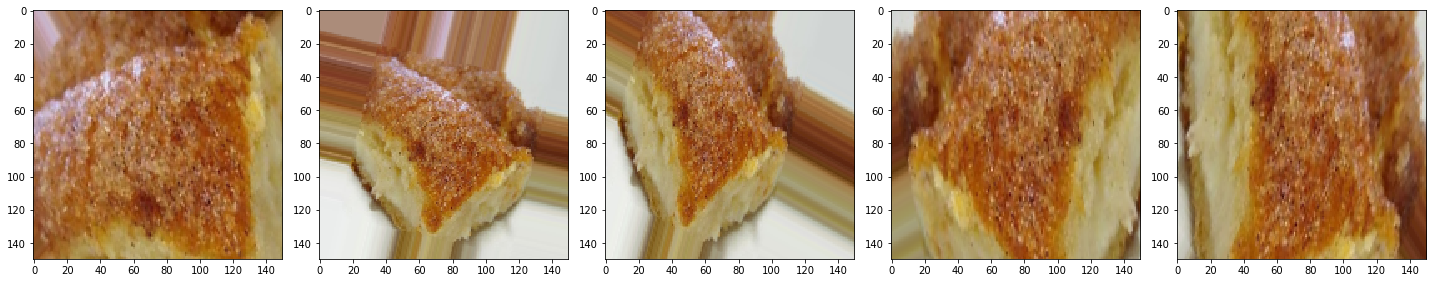

In [47]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[7][0][0] for i in range(5)]
plotImages(augmented_images)

Many cheese cakes!

Found 78 images belonging to 2 classes.


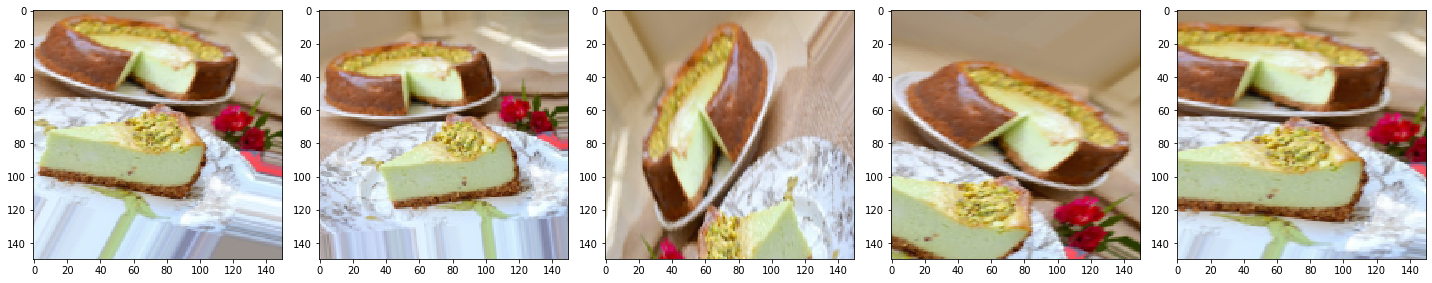

In [35]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[7][0][0] for i in range(5)]
plotImages(augmented_images)

In [36]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 20 images belonging to 2 classes.


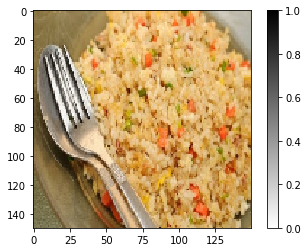

In [37]:
sample = val_data_gen[1][0][0]
plt.figure()
plt.imshow(sample, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Simple DNN model

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4320064   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 4,328,642
Trainable params: 4,328,642
Non-trainable params: 0
_________________________________________________________________


In [49]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
8/8 [==============================] - 2s 225ms/step - loss: 6.1409 - accuracy: 0.6282 - val_loss: 1.0185 - val_accuracy: 0.5500
Epoch 2/100
8/8 [==============================] - 1s 179ms/step - loss: 2.6340 - accuracy: 0.5897 - val_loss: 5.4702 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 1s 184ms/step - loss: 5.3766 - accuracy: 0.5256 - val_loss: 7.5580 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 2s 200ms/step - loss: 4.4412 - accuracy: 0.5256 - val_loss: 2.3750 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 2s 208ms/step - loss: 1.2137 - accuracy: 0.7564 - val_loss: 1.1503 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 2s 220ms/step - loss: 0.7386 - accuracy: 0.7821 - val_loss: 0.9603 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 2s 202ms/step - loss: 0.6364 - accuracy: 0.7436 - val_loss: 0.7611 - val_accuracy: 0.7000
Epoch 8/100
8

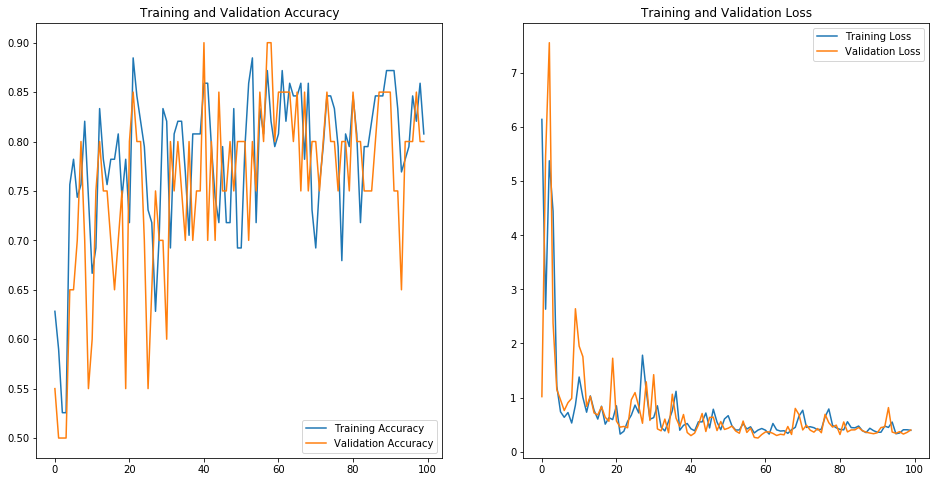

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test on unseen image from internet

To test the modol, I simply download few images of fried rice and cheesecake from internet randomly.

In [51]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)

In [52]:
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

Total test file:  4


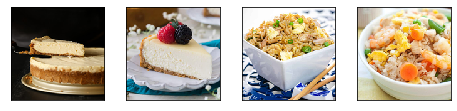

In [53]:
test_image = list(test_dir.glob('*'))

plt.figure(figsize=(10,10))
for i in range(len(test_image)):
    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
plt.show()

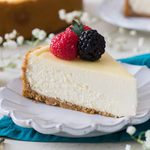

In [54]:
sample_img1 = PIL.Image.open(test_image[1]).resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
sample_img1

In [61]:
test_array = []
predictions = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    test_array.append(img_array)
    pred = model.predict(img_array)
    predictions.append(pred)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence score."
        .format(classes[np.argmax(pred)], 100 * np.max(score))
    )
#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

This image most likely belongs to cheesecake with a 73.11 percent confidence score.
This image most likely belongs to cheesecake with a 73.11 percent confidence score.
This image most likely belongs to cheesecake with a 73.11 percent confidence score.
This image most likely belongs to fried_rice with a 73.11 percent confidence score.


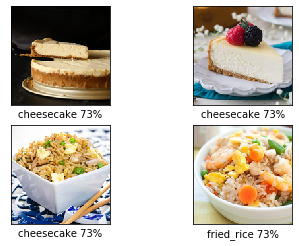

In [62]:
for i in range(len(test_image)):
    predictions_array, img = predictions[i], test_image[i]

    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)


    plt.xlabel("{} {:2.0f}%".format(classes[predicted_label],100*np.max(score)))

### Manually Calculate F1 Score

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.


*Notes*
Based on documentation from sklearn, the 'average' parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned.

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [63]:
y_true = [0, 0, 1, 1]
y_pred = [0, 0, 0, 1]

f1_score = f1_score(y_true, y_pred)
print('F1 score is ', f1_score)

F1 score is  0.6666666666666666
